# TASK 1

## Downloading Prerequisite modules

In [ ]:
!pip install ucimlrepo

## Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from ucimlrepo import fetch_ucirepo
import numpy as np
import math
## dont judge me for this next one
import warnings

## Getting and cleaning data
Removing "B" from boston dataset
<br>There doesnt seem to be any Null entries nor duplicates in the data

In [ ]:

def init():
  # fetch dataset
  wine_fetch = fetch_ucirepo(id=109)
  wine = wine_fetch.data.features.assign(target = wine_fetch.data.targets.values)

  boston = pd.read_csv("/content/sample_data/boston.csv")
  # removing B
  boston = boston.loc[:, boston.columns.drop("B")]

  # Drop NULL vals (none in these sets)
  boston.dropna(inplace=True)
  wine.dropna(inplace=True)

  # Drop duplicates
  boston.drop_duplicates(inplace=True)
  wine.drop_duplicates(inplace=True)

  wine_features = wine.loc[:, wine.columns.drop("target")]
  wine_target = wine.loc[:, "target"]

  boston_features = boston.loc[:, boston.columns.drop("MEDV")]
  boston_target = boston.loc[:, "MEDV"]
  return wine, wine_features, wine_target, boston, boston_features, boston_target

wine, wine_features, wine_target, boston, boston_features, boston_target = init()

In [ ]:
wine

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline,target
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,3
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,3
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,3
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,3


## Checking for inconsistencies by making histogram for each class for wine dataset
looks okay

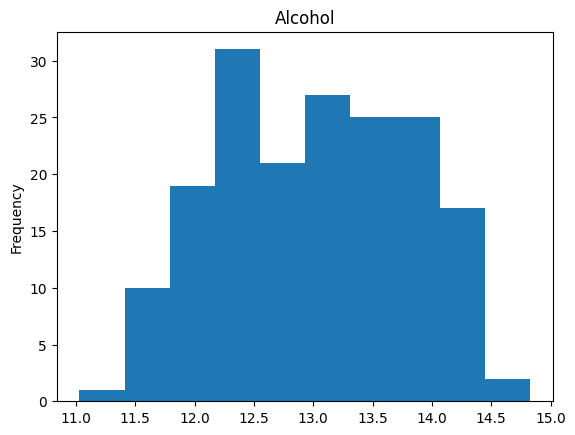

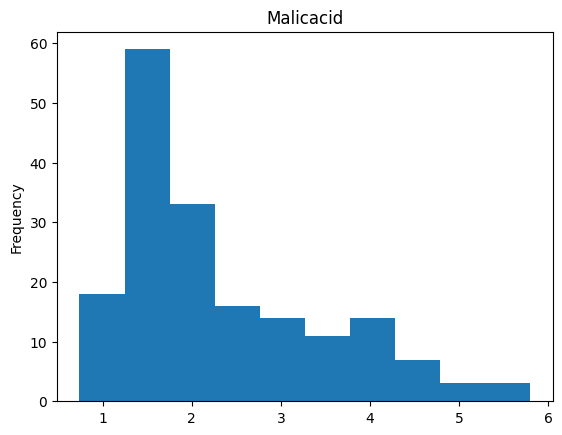

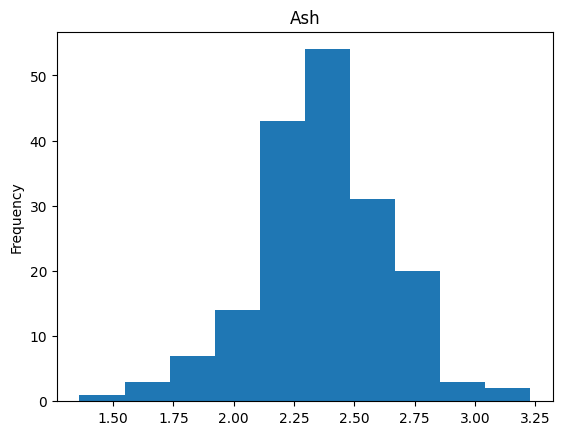

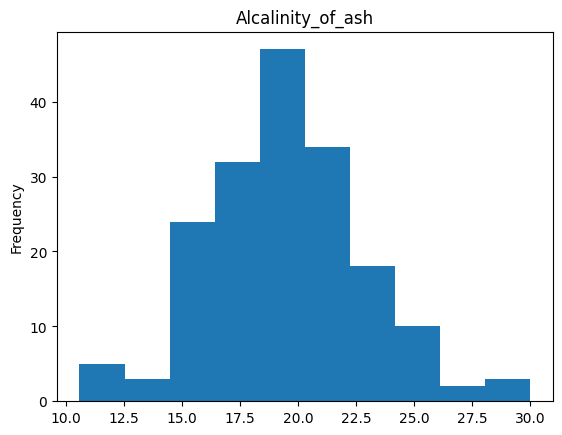

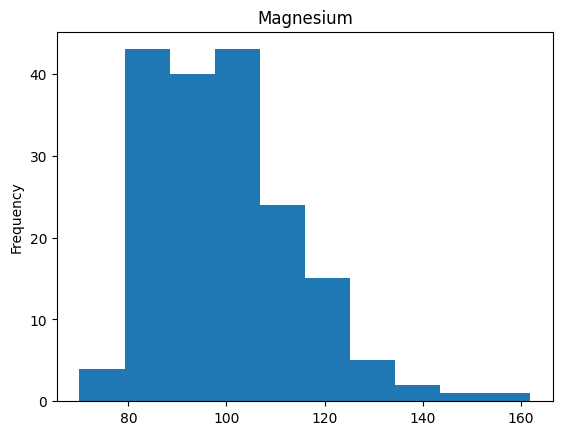

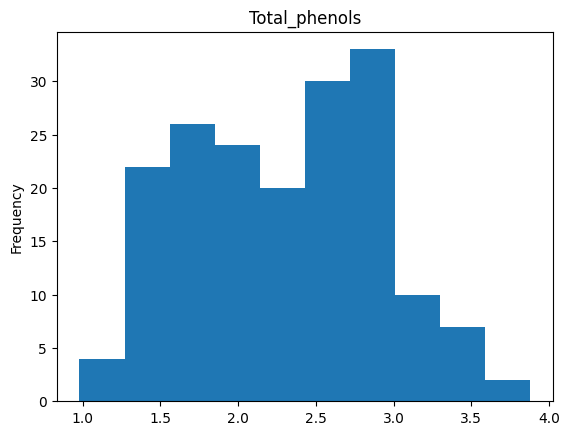

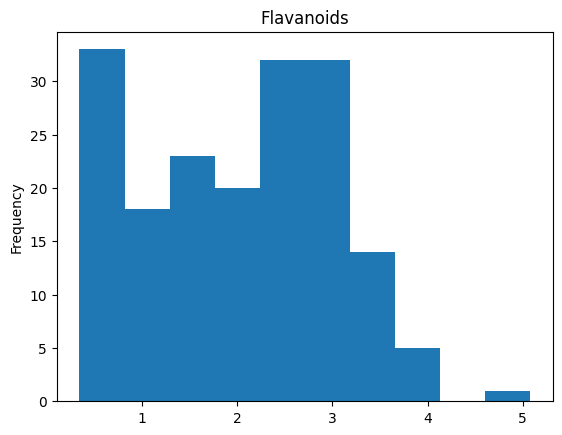

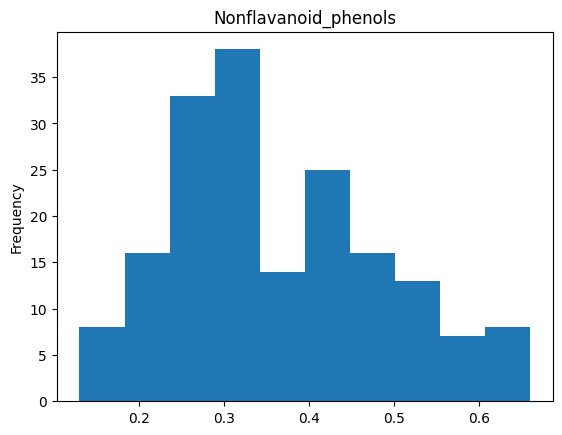

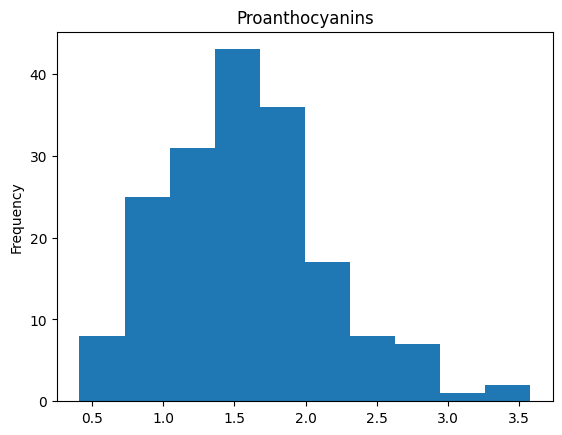

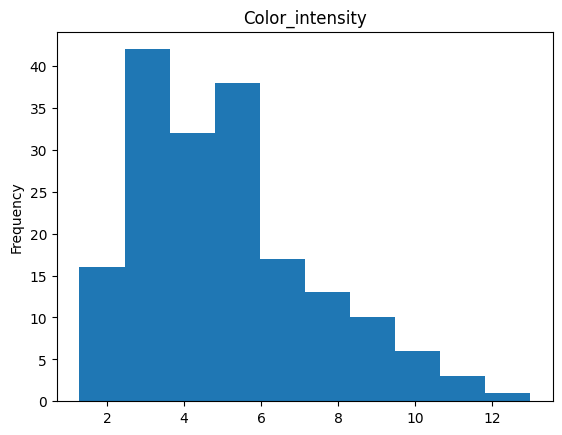

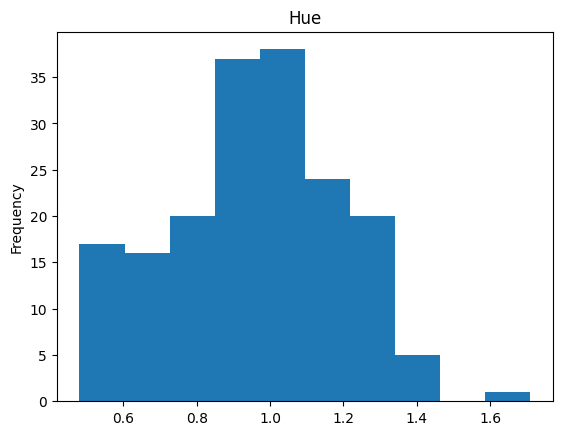

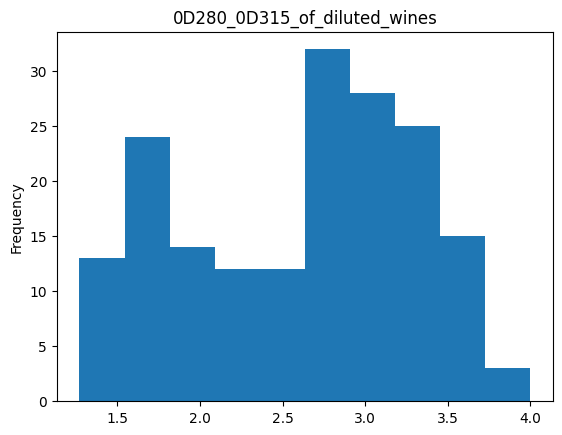

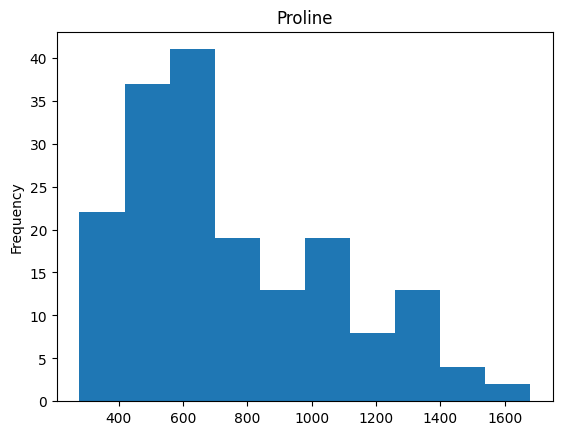

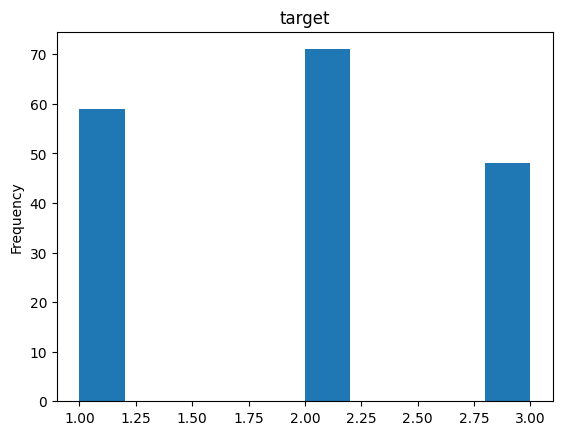

In [ ]:
for x in wine_features.columns:
  wine_features[x].plot(kind = "hist")
  plt.title(x)
  plt.show()
wine_target.plot(kind="hist")
plt.title("target")
plt.show()

## Checking for inconsistencies by making histogram for each class for boston dataset
looks okay too.

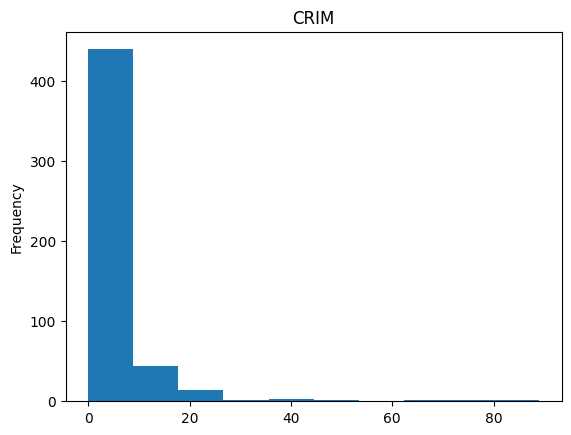

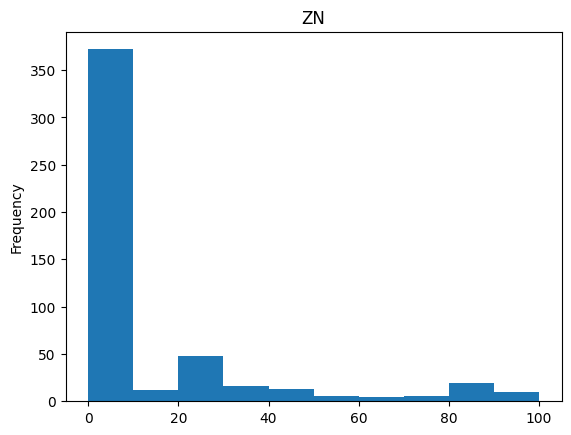

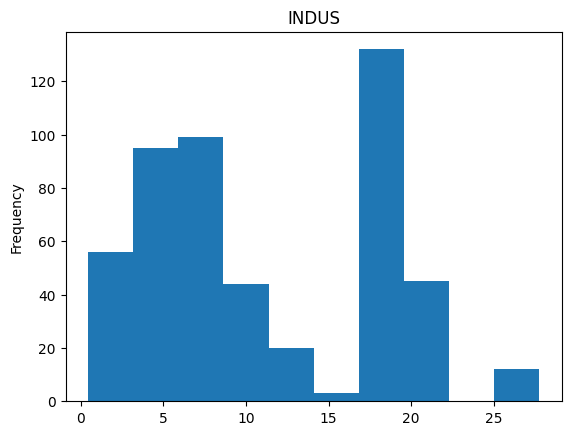

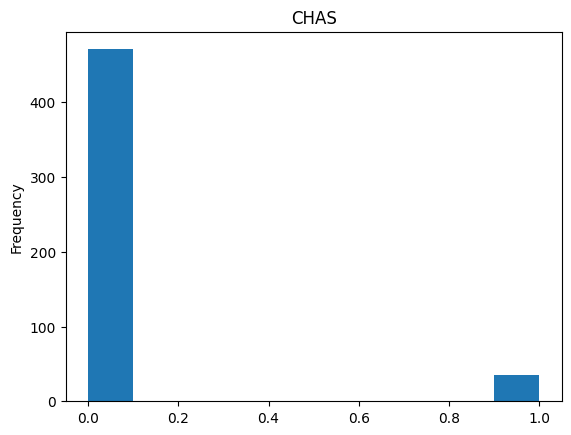

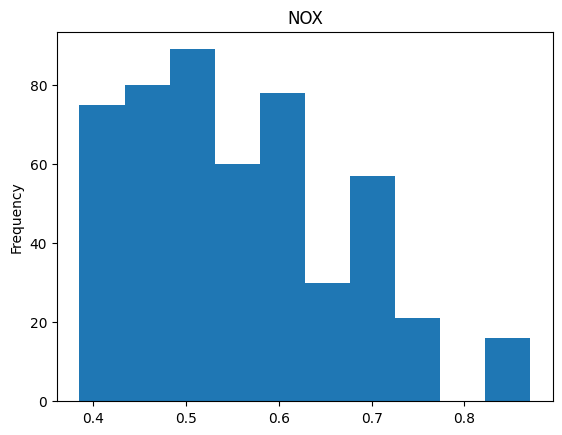

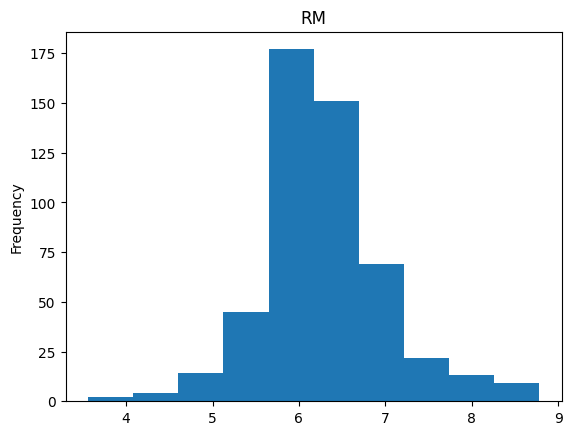

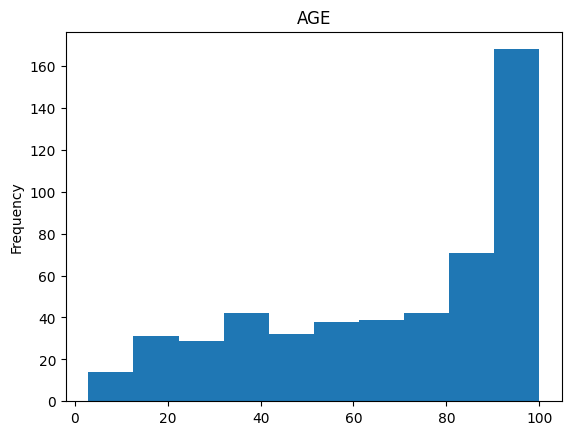

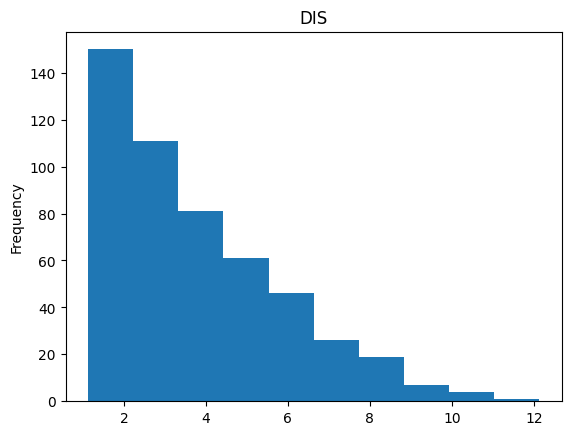

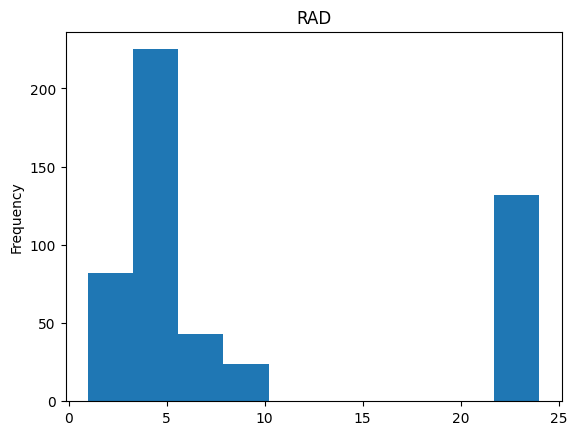

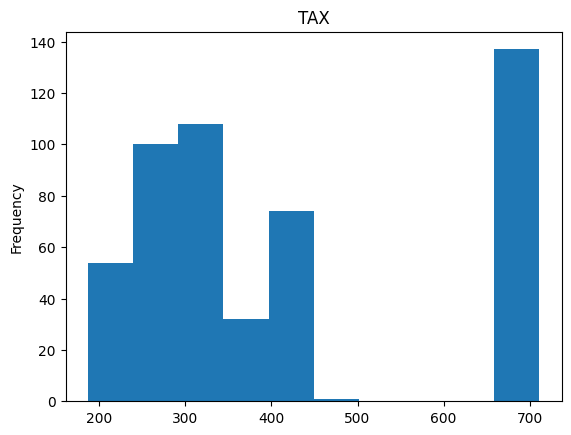

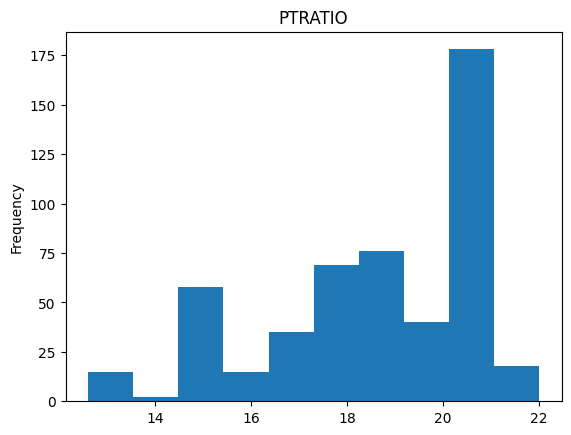

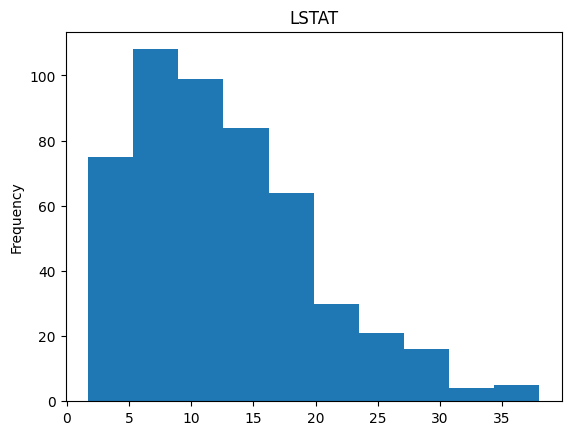

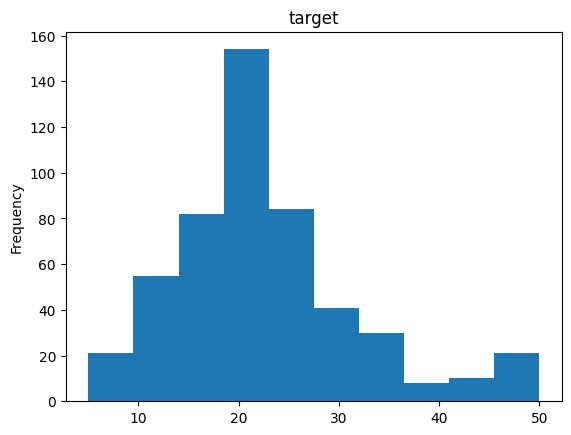

In [ ]:
for x in boston_features.columns:
  boston_features[x].plot(kind = "hist")
  plt.title(x)
  plt.show()
boston_target.plot(kind="hist")
plt.title("target")
plt.show()

## Getting Corelation to get a better idea of the data

In [ ]:
wine.corr().loc[:, "target"]

Alcohol                        -0.328222
Malicacid                       0.437776
Ash                            -0.049643
Alcalinity_of_ash               0.517859
Magnesium                      -0.209179
Total_phenols                  -0.719163
Flavanoids                     -0.847498
Nonflavanoid_phenols            0.489109
Proanthocyanins                -0.499130
Color_intensity                 0.265668
Hue                            -0.617369
0D280_0D315_of_diluted_wines   -0.788230
Proline                        -0.633717
target                          1.000000
Name: target, dtype: float64

In [ ]:
boston.corr().loc[:, "MEDV"]

CRIM      -0.388305
ZN         0.360445
INDUS     -0.483725
CHAS       0.175260
NOX       -0.427321
RM         0.695360
AGE       -0.376955
DIS        0.249929
RAD       -0.381626
TAX       -0.468536
PTRATIO   -0.507787
LSTAT     -0.737663
MEDV       1.000000
Name: MEDV, dtype: float64

## Making scatter plots for boston data set to see if non linear relations between features and data

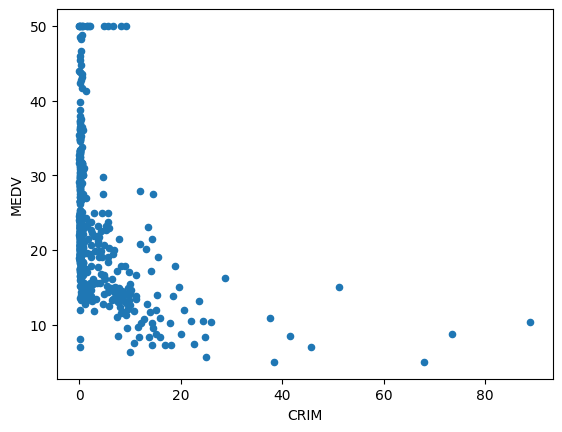

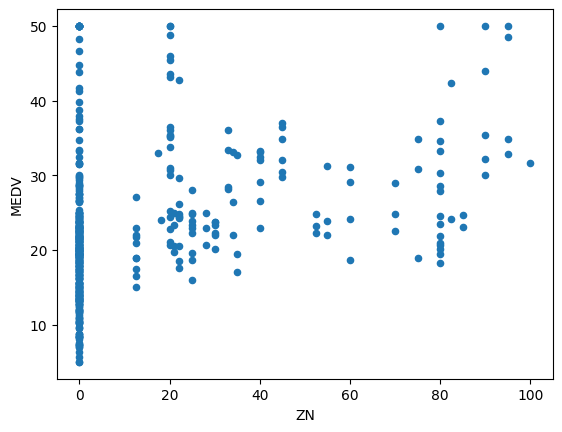

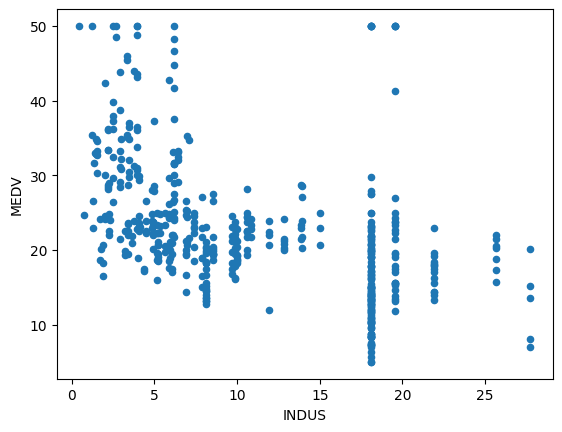

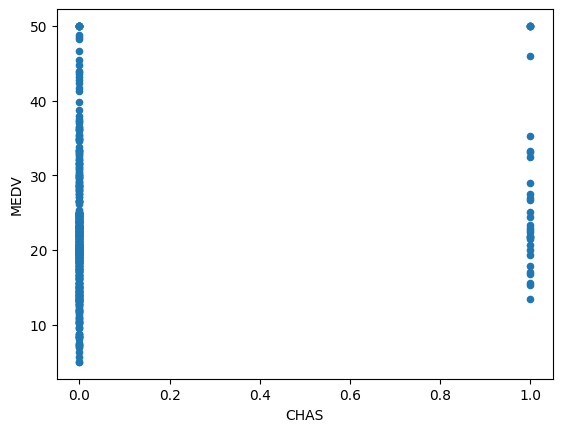

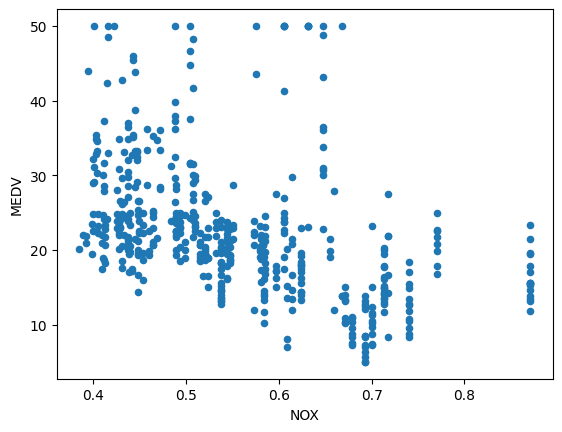

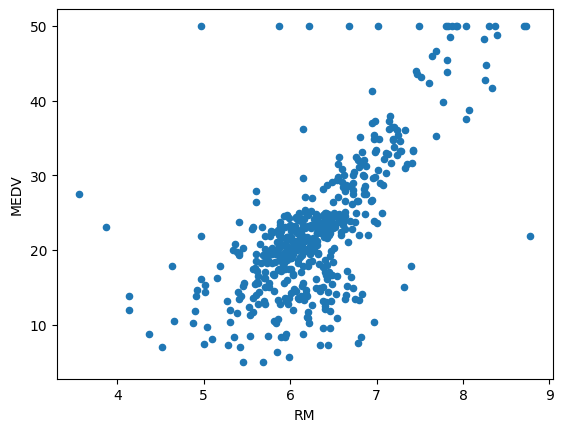

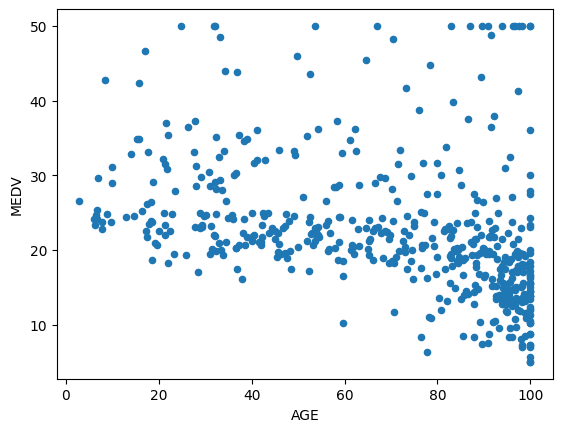

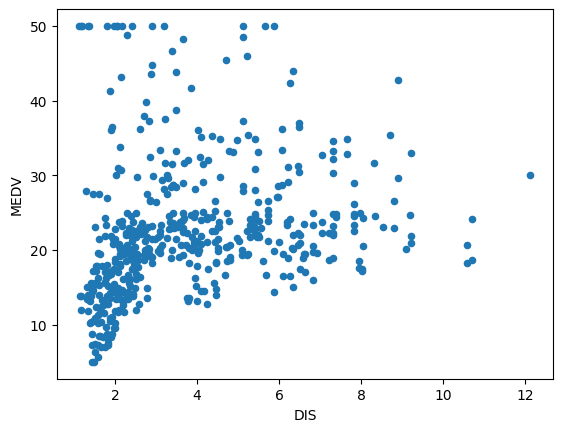

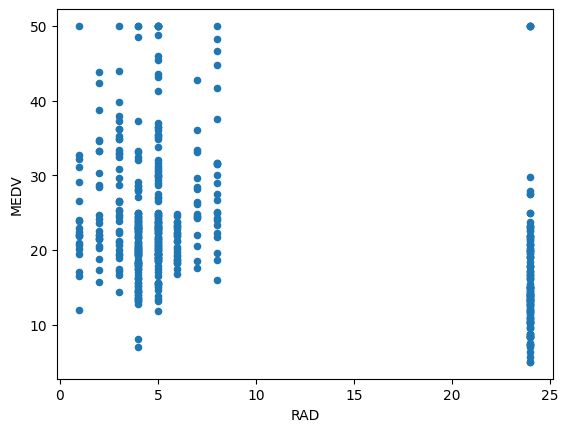

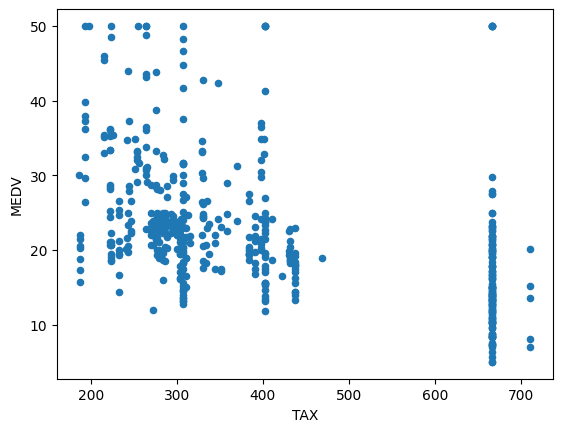

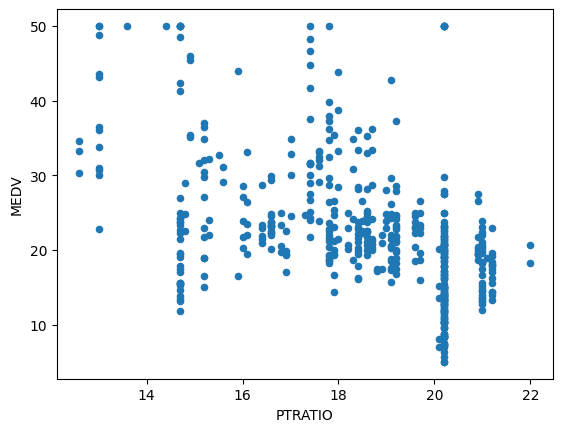

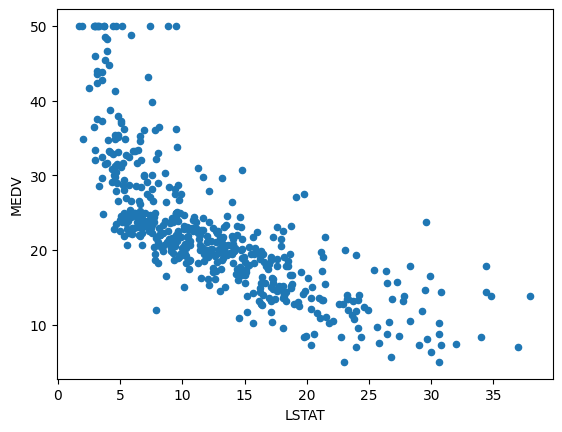

In [ ]:
for col in boston_features.columns:
  boston.plot(kind = "scatter",x = col, y = "MEDV")

It seems that :
 * **CRIM is 1/x looking**
 * ZN is kind of all over the place
 * **INDUS is 1/x looking**
 * **CHAS is Indicator looking**
 * NOX is kind of all over the place
 * RM seems Linear
 * AGE seems linear
 * DIS seems linear
 * RAD is all over the place
 * TAX is all over the place
 * PTRATIO is all over the place
 * **LSTAT is 1/x looking**

# TASK 2

## Models
Inspired from https://github.com/rabbanyk/comp551-notebooks

### Optimizers

In [ ]:
class StochasticGradientDescent:
  """
    Uses ADAM to do descent rather than simple SGD
  """
  def __init__(self, learning_rate=1e-8, max_iters=1e5, epsilon=1e-2, batch_size = 1000
               , B_momentum = 0.6, B_adaptive = 0.6, epsilon_adaptive = 0.01):
    self.learning_rate = learning_rate
    self.max_iters = max_iters
    self.epsilon = epsilon
    self.batch_size = batch_size
    self.B_momentum = B_momentum
    self.B_adaptive = B_adaptive
    self.epsilon_adaptive = epsilon_adaptive

  def optimize(self, x, y, gradien_fn):
    """
      Assumes:
        x.shape = (N, D) or (1, D)
        for lin. reg.:
          y.shape = (N, 1) or (1, 1)
        for log. reg.:
          y.shape = (N, C) or (1, C)
      Returns:
        for lin. reg.:
          w with w.shape = (D, 1)
        for log. reg.:
          w with w.shape = (D, C)
    """
    # Setting up ADAM variables
    N,D = x.shape
    _, C = y.shape
    M = np.zeros((D, C))
    S = np.zeros((D, C))
    w = np.zeros((D, C))

    g = np.inf
    t = 0

    ## if batch_size > number of instances, Just use number of instances
    ## This is why Gradient Descent class below works
    batch_size = min(N, self.batch_size)

    x_p = np.ones(1)
    y_p = np.ones(1)

    # the code snippet below is for gradient descent
    while np.linalg.norm(g) > self.epsilon and t < self.max_iters :
      # random batch
      s = np.random.randint(N, size = batch_size)
      x_p = x[s,:]
      y_p = y[s]

      g = gradien_fn(x_p, y_p, w)
      M = self.B_momentum * M + (1 - self.B_momentum) * g
      S = self.B_adaptive * S + (1 - self.B_adaptive) * np.square(g)
      M_hat = M / (1 - self.B_momentum)
      S_hat = S / (1 - self.B_adaptive)
      w = w - self.learning_rate / (np.sqrt(S_hat) + self.epsilon_adaptive) * M_hat
      # print(self.w)
      t += 1
    return w


class GradientDescent(StochasticGradientDescent):
  """
    Uses Stochastic Gradient Descent but with an infite batch size to use the
    whole data set.
  """
  def __init__(self, learning_rate=1e-8, max_iters=1e5, epsilon=1e-2
               , B_momentum = 0.6, B_adaptive = 0.6, epsilon_adaptive = 0.01):
    batch_size = np.inf
    StochasticGradientDescent.__init__(self, learning_rate=learning_rate,
                                       max_iters=max_iters,
                                       epsilon=epsilon,
                                       batch_size=batch_size,
                                       B_momentum=B_momentum,
                                       B_adaptive=B_adaptive,
                                       epsilon_adaptive=epsilon_adaptive)

### Linear Regression


In [ ]:
class LinearRegression:
  def __init__(self, add_bias=True):
    self.add_bias = add_bias

  class Analytical:
    def optimize(self, x, y, gradien_fn = lambda x: x):
      return np.linalg.inv(x.T @ x) @ x.T @ y

  def fit(self, x, y, optimizer = Analytical()):
    """
      This expects a N , D for x and N , 1 for y where N = number of instances,
      D = number of features.
    """
    if x.ndim == 1:
      x = x[None, :]
      y = np.array(y)[None][None]
    elif y.ndim == 1:
      y = y[:, None]
    if self.add_bias:
      N = x.shape[0]
      x = np.column_stack([x, np.ones(N)])

    def gradient(x, y, w):
      N, D = x.shape
      yh = np.dot(x, w)
      return 1./N * np.dot(x.T, (yh - y))

    self.w = optimizer.optimize(x, y, gradien_fn = gradient)
    return self

  def predict(self, x):
    if x.ndim == 1:
      x = x[None, :]
    if self.add_bias:
      N, D = x.shape
      x = np.column_stack([x, np.ones(N)])
    yh = np.dot( x, self.w)            #predict output
    return yh

  def loss(self, x, y):
    if x.ndim == 1:
      x = x[None, :]
      y = np.array(y)[None, None]
    elif y.ndim == 1:
      y = y[:, None]
    if self.add_bias:
      N = x.shape[0]
      x = np.column_stack([x, np.ones(N)])
    N, D = x.shape
    return 1./N * 1/2. * np.linalg.norm(y - np.dot(x, self.w))**2

  def mean_square_error(self, x, y):
    if y.ndim == 0:
      y_p = np.array(y)[None, None]
    elif y.ndim == 1:
      y = y[:, None]
    predicted = self.predict(x)
    N = y.shape[0]
    return np.mean(np.square(predicted - y))


  def get_stats(self, x, y):
    ans = (self.mean_square_error(x, y),)
    return ans

  def print_stats(self, x, y):
    print(f"Mean Square Error = {self.get_stats(x, y)[0]}")



### Logistic Regression


In [ ]:
class MulticlassLogisticRegression:
  def __init__(self, add_bias=True):
    self.add_bias = add_bias

  def softmax(self, x):
    below = np.exp(x).sum(axis = 1)[:, None]
    repeat = np.repeat(below, x.shape[1], axis = 1)
    return np.exp(x)/repeat

  def fit(self, x, y, optimizer = StochasticGradientDescent(learning_rate=1e-6,max_iters=10000)):
    if x.ndim == 1:
      x = x[None, :]
      y = y[None, :]

    if self.add_bias:
      N = x.shape[0]
      x = np.column_stack([x,np.ones(N)])

    N,D = x.shape

    def gradient(x, y, w):
      N, D = x.shape
      yh = self.softmax(np.dot(x, w))
      return 1./N * np.dot(x.T,(yh - y))

    self.w = optimizer.optimize(x, y, gradien_fn = gradient)
    return self

  def predict(self, x):
    if x.ndim == 1:
      x = x[None, :]
    if self.add_bias:
      N = x.shape[0]
      x = np.column_stack([x, np.ones(N)])
    yh = self.softmax(np.dot(x,self.w))            #predict output
    return yh

  def loss(self, x, y):
    """
      Warning ::: UNDERFLOW / OVERFLOW, didnt implement fix seen in class
    """
    if x.ndim == 1:
      x = x[None, :]
      y = y[None, :]

    if self.add_bias:
      N, _ = x.shape
      x = np.column_stack([x, np.ones(N)])

    z = np.dot(x,self.w)
    right_term = np.log(np.sum(np.exp(z), axis = 1)[:, None])
    # the following matrix contains the values we are interested in, "y{n} @ z{n}"
    # In its diagonal
    weird_matrix = y @ z.T
    diag = np.diagonal(weird_matrix)[:, None]
    J = - 1./N * np.sum((diag - right_term), axis = 0)
    return J

  def build_confusion_matrix(self, x, y):
    if x.ndim == 1:
      x = x[None, :]
      y = y[None, :]
    yh = self.predict(x)
    col_range = range(1, self.w.shape[1]+1)
    y_dataframe = pd.Categorical(pd.DataFrame(y, columns=col_range).idxmax(1), categories=col_range)
    yh_dataframe = pd.Categorical(pd.DataFrame(yh, columns=col_range).idxmax(1), categories = col_range)
    self.confusion_matrix = pd.crosstab(yh_dataframe, y_dataframe, colnames=['Actual'],
                                        rownames=['Predicted'], margins=True, dropna=False)
    return self.confusion_matrix.copy()

  def get_stats(self, x, y):
    if x.ndim == 1:
      x = x[None, :]
      y = y[None, :]
    confusion_df = self.build_confusion_matrix(x, y)
    accuracy = confusion_df.iloc[:-1, :-1].to_numpy().diagonal().sum(dtype = 'float64') / \
                        confusion_df.iloc[-1, :-1].to_numpy().sum(dtype= 'float64')
    precision = confusion_df.iloc[:-1, :-1].to_numpy().diagonal() / \
                        confusion_df.iloc[:-1, -1].to_numpy()
    recall = confusion_df.iloc[:-1, :-1].to_numpy().diagonal() / \
                        confusion_df.iloc[-1, :-1].to_numpy()
    F1_score = 2 * precision * recall / (precision + recall)

    C = self.w.shape[1]
    accuracy = np.sum(accuracy, where= np.logical_not(np.isnan(accuracy) )) / C
    precision = np.sum(precision, where= np.logical_not(np.isnan(precision)) ) / C
    recall = np.sum(recall, where= np.logical_not(np.isnan(recall) )) / C
    F1_score = np.sum(F1_score, where= np.logical_not(np.isnan(F1_score)) ) / C

    return F1_score, confusion_df, accuracy, precision, recall

  def print_stats(self, x, y):
    F1_score, confusion_df, accuracy, precision, recall = self.get_stats(x, y)
    print(f"Confusion Matrix = \n{confusion_df}")
    print(f"Average Accuracy = {accuracy}")
    print(f"Average Precision = {precision}")
    print(f"Average Recall = {recall}")
    print(f"Average F1 score = {F1_score}")


## Applying both models

### Boston

#### Analytical Linear Regression


Witout modifying dataset

In [ ]:
def bostonLR():
  x_boston = boston_features.to_numpy()
  y_boston = boston_target.to_numpy()
  SGDLR = LinearRegression()
  SGDLR.fit(x_boston, y_boston)
  print(SGDLR.loss(x_boston, y_boston))
  index = 1
  print(f"predicted {SGDLR.predict(x_boston[index])}")
  print(f"real = {y_boston[index]}")

bostonLR()

11.214840719744965
predicted [[25.05683368]]
real = 21.6


with dataset modification

In [ ]:
def boston_modified_LR():
  boston_features_transformed = boston_features.copy()

  boston_features_transformed.loc[:, ["CRIM", "INDUS", "LSTAT"]] = \
  (boston_features_transformed.loc[:, ["CRIM", "INDUS", "LSTAT"]])\
  .apply( lambda x: 1/(x) , axis = 1)

  boston_features_transformed.loc[:, "AGE"] = \
  (boston_features_transformed.loc[:, "AGE"])\
  .apply( lambda x: np.sqrt(-x + 100))

  x_boston = boston_features_transformed.to_numpy()
  y_boston = boston_target.to_numpy()

  ALM = LinearRegression()
  ALM.fit(x_boston, y_boston)
  print(ALM.loss(x_boston, y_boston))
  index = 0
  print(f"predicted value = {ALM.predict(x_boston[index])}")
  print(f"real value = {y_boston[index]}")
  return x_boston, y_boston

x_boston, y_boston = boston_modified_LR()

9.73275440463939
predicted value = [[27.18245633]]
real value = 24.0


#### Stochastic Gradient descent for Linear Regression

In [ ]:
def boston_LR_SGD():
  SGDLR = LinearRegression()
  SGDLR.fit(x_boston, y_boston, optimizer=StochasticGradientDescent(learning_rate= 0.01))
  print(SGDLR.loss(x_boston, y_boston))
  return SGDLR
SGDLR = boston_LR_SGD()

12.34041823684104


In [ ]:
def boston_LR_SGD_test():
  index = [0, 123]
  print(f"predicted value = {SGDLR.predict(x_boston[index])}")
  print(f"real value = {y_boston[index]}")
boston_LR_SGD_test()

predicted value = [[29.2471348 ]
 [19.30911855]]
real value = [24.  17.3]


### Wine


Need to use One Hot Encoding

In [ ]:
def wine_SGD():
  x_wine = wine_features.to_numpy()
  # Gets One Hot encoding for y
  y_wine = pd.get_dummies(wine_target).to_numpy()

  LR = MulticlassLogisticRegression()
  LR.fit(x_wine, y_wine, optimizer=StochasticGradientDescent(learning_rate=1e-6,max_iters=100000))
  print(f"Loss = {LR.loss(x_wine, y_wine)}")

wine_SGD()

Loss = [0.30375469]


We can also use Normal Gradient Descent

In [ ]:
def wine_GD():
  x_wine = wine_features.to_numpy()
  # Gets One Hot encoding for y
  y_wine = pd.get_dummies(wine_target).to_numpy()

  LR = MulticlassLogisticRegression()
  LR.fit(x_wine, y_wine, optimizer=GradientDescent(learning_rate=1e-6,max_iters=100000))
  print(f"Loss = {LR.loss(x_wine, y_wine)}")
  return LR, x_wine, y_wine
LR, x_wine, y_wine = wine_GD()

Loss = [0.30383956]


In [ ]:
def wine_test():
  index = 124
  a = LR.predict(x_wine[index])
  print(f"predicted probabilities values = {a}")
  ## Choice
  splice = np.where(a==np.max(a))
  neg_splice =np.where(a!=np.max(a))
  a[splice] = 1
  a[neg_splice] = 0
  print(f"predicted values = {a}")
  print(f"real value = {y_wine[index]}")
wine_test()

predicted probabilities values = [[0.00549909 0.90353524 0.09096567]]
predicted values = [[0. 1. 0.]]
real value = [0 1 0]


# TASK 3


## JOB 1

### Split into Training (80%) and Test (20%)

In [ ]:
def split_data(data, training_percentage=0.8, shuffle=True):
  """
  Shuffles data, then
  Splits data into 80/20 portions
  """
  len = data.shape[0]
  cut_off_index = math.floor(training_percentage * len)
  shuffled_data = data
  if shuffle:
    shuffled_data = data.sample(frac = 1)
  training_shuffled_data = shuffled_data.head(cut_off_index)
  test_shuffled_data = shuffled_data.tail(len - cut_off_index)
  test_shuffled_data
  return (training_shuffled_data, test_shuffled_data)

boston_training, boston_test = split_data(boston)
wine_training, wine_test = split_data(wine)

### Training and getting MSE for Boston

In [ ]:
def get_x_and_y_boston(data):
  x_boston = data.loc[:, data.columns.drop("MEDV")].to_numpy()
  y_boston = data.loc[:, "MEDV"].to_numpy()
  return x_boston, y_boston

def bostonMSE_test():
  x_boston_training, y_boston_training = get_x_and_y_boston(boston_training)
  x_boston_test, y_boston_test = get_x_and_y_boston(boston_test)
  Linear_regression = LinearRegression()
  Linear_regression.fit(x_boston_training, y_boston_training)
  print(f"Loss on test set :  {Linear_regression.loss(x_boston_test, y_boston_test)}")
  Linear_regression.print_stats(x_boston_test, y_boston_test)
bostonMSE_test()

Loss on test set :  11.874979229661488
Mean Square Error = 23.749958459322972


### Training and Getting stats for wine

In [ ]:
def get_x_and_y_wine(data):
  x_wine = data.loc[:, data.columns.drop("target")].to_numpy()
  y_wine = pd.get_dummies(data.loc[:, "target"]).to_numpy()
  return x_wine, y_wine

def wine_stats_test():
  x_training_wine, y_training_wine = get_x_and_y_wine(wine_training)
  x_test_wine, y_test_wine = get_x_and_y_wine(wine_test)

  Logistic_regression = MulticlassLogisticRegression()
  Logistic_regression.fit(x_training_wine, y_training_wine, optimizer=StochasticGradientDescent(learning_rate=1e-6,max_iters=100000))

  print(f"loss = {Logistic_regression.loss(x_test_wine, y_test_wine)[0]}")
  Logistic_regression.print_stats(x_test_wine, y_test_wine)

wine_stats_test()

loss = 0.25240520205649253
Confusion Matrix = 
Actual      1   2  3  All
Predicted                
1          16   1  0   17
2           1  11  0   12
3           0   0  7    7
All        17  12  7   36
Average Accuracy = 0.3148148148148148
Average Precision = 0.9526143790849674
Average Recall = 0.9526143790849674
Average F1 score = 0.9526143790849674


## JOB 2


### k-fold cross-validation

In [ ]:
def kfold_test_models(data_training, data_test, number_of_folds,get_x_and_y_fn, model_class):

  def kfold_trained_models(data, number_of_folds, get_x_y_fn, model_class):
    """
      data is A dataframe of all the training points, supposed to be the training
        dataframe
      number of folds is how many partitions of the data do we wanna make
      get_x_y_fn is a function that returns x and y for the specified data, either
        get_x_y_boston or get_x_y_wine
    """
    training_list = np.array_split(data.to_numpy(), number_of_folds)
    models = []
    for i in range(number_of_folds):
      model = model_class()
      models.append(model)

      data_list = training_list.copy()
      data_list.pop(i)
      data_training = data_list
      training = np.concatenate(data_training, axis = 0)
      x_training, y_training = get_x_y_fn(pd.DataFrame(training, columns=data.columns))

      validation = training_list.copy()[i]
      x_validation, y_validation = get_x_y_fn(pd.DataFrame(validation, columns=data.columns))
      model.fit(x_training, y_training)
      print("-"*50)
      print(f"Model number {i}, Stats on validation :")
      model.print_stats(x_validation, y_validation)
    return models

  models = kfold_trained_models(data_training, number_of_folds, get_x_and_y_fn, model_class)
  x_test, y_test = get_x_and_y_fn(data_test)
  print("\n\n")
  for i in range(number_of_folds):
    print("-"*50)
    print(f"Model number {i}, Stats on test set :")
    models[i].print_stats(x_test, y_test)


#### Result on boston

In [ ]:
kfold_test_models(boston_training, boston_test, 5, get_x_and_y_boston, LinearRegression)

--------------------------------------------------
Model number 0, Stats on validation :
Mean Square Error = 27.546387431726785
--------------------------------------------------
Model number 1, Stats on validation :
Mean Square Error = 20.36470626259235
--------------------------------------------------
Model number 2, Stats on validation :
Mean Square Error = 21.253362874568456
--------------------------------------------------
Model number 3, Stats on validation :
Mean Square Error = 21.653705042667834
--------------------------------------------------
Model number 4, Stats on validation :
Mean Square Error = 31.13340670415268



--------------------------------------------------
Model number 0, Stats on test set :
Mean Square Error = 23.6929931662086
--------------------------------------------------
Model number 1, Stats on test set :
Mean Square Error = 23.965500883891792
--------------------------------------------------
Model number 2, Stats on test set :
Mean Square Error = 24

#### Result on wine

For this test i have reduced the maximum number of iterations in the default optimizer for multiclassLogisticRegression, hence the horrible performance

In [ ]:
kfold_test_models(wine_training, wine_test, 5, get_x_and_y_wine, MulticlassLogisticRegression)

--------------------------------------------------
Model number 0, Stats on validation :
Confusion Matrix = 
Actual     1   2  3  All
Predicted               
1          8   2  0   10
2          0  13  2   15
3          0   0  4    4
All        8  15  6   29
Average Accuracy = 0.28735632183908044
Average Precision = 0.888888888888889
Average Recall = 0.8444444444444444
Average F1 score = 0.8518518518518517
--------------------------------------------------
Model number 1, Stats on validation :
Confusion Matrix = 
Actual     1   2  3  All
Predicted               
1          6   0  2    8
2          1  15  3   19
3          0   0  2    2
All        7  15  7   29
Average Accuracy = 0.26436781609195403
Average Precision = 0.8464912280701755
Average Recall = 0.7142857142857143
Average F1 score = 0.7089324618736383
--------------------------------------------------
Model number 2, Stats on validation :
Confusion Matrix = 
Actual     1   2   3  All
Predicted                
1          6   2  

<ipython-input-15-7d2cb49ff781>:78: RuntimeWarning: invalid value encountered in divide
  precision = confusion_df.iloc[:-1, :-1].to_numpy().diagonal() / \


--------------------------------------------------
Model number 3, Stats on validation :
Confusion Matrix = 
Actual     1   2  3  All
Predicted               
1          6   1  3   10
2          1  11  4   16
3          0   0  2    2
All        7  12  9   28
Average Accuracy = 0.2261904761904762
Average Precision = 0.7625000000000001
Average Recall = 0.6653439153439153
Average F1 score = 0.618411000763942
--------------------------------------------------
Model number 4, Stats on validation :
Confusion Matrix = 
Actual      1  2  3  All
Predicted               
1          11  1  0   12
2           3  6  5   14
3           0  0  2    2
All        14  7  7   28
Average Accuracy = 0.2261904761904762
Average Precision = 0.7817460317460316
Average Recall = 0.6428571428571428
Average F1 score = 0.6206756206756207



--------------------------------------------------
Model number 0, Stats on test set :
Confusion Matrix = 
Actual      1   2  3  All
Predicted                
1          16   2  

<ipython-input-15-7d2cb49ff781>:78: RuntimeWarning: invalid value encountered in divide
  precision = confusion_df.iloc[:-1, :-1].to_numpy().diagonal() / \


## JOB 3

In [ ]:
def growing_training_set_plot(data, start, end, step, get_x_y_fn, model_class, performance_metric):
  results = []
  for i in range(start, end, step):
    training, test = split_data(data, training_percentage=0.01 * i)
    x_training, y_training = get_x_y_fn(training)
    model = model_class()
    model.fit(x_training, y_training)

    x_test, y_test = get_x_y_fn(test)
    # so far, this is MSE for Linear Regression and accuracy for MLR
    results.append(model.get_stats(x_test, y_test)[0])
  x = range(start, end, step)
  plt.plot(x, results, marker = 'o')
  plt.xlabel("Training data %")
  plt.ylabel(performance_metric)
  plt.show()

### Applied to boston dataset
Performance metric here is Mean Square Error and so the higher the worse

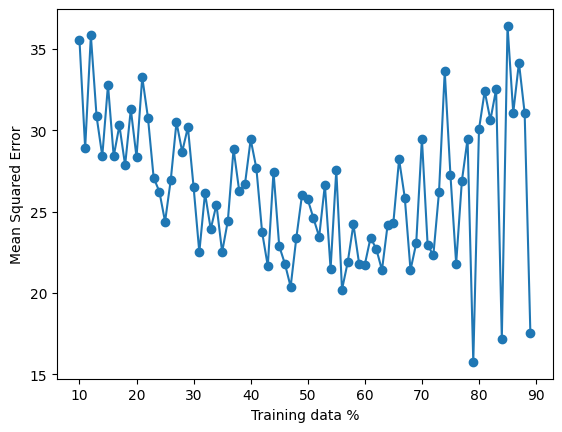

In [ ]:
growing_training_set_plot(boston, 10, 90, 1, get_x_and_y_boston, LinearRegression, "Mean Squared Error")

### Applied to wine dataset
Here performance metric is F1_score so the higher the better

<ipython-input-15-7d2cb49ff781>:78: RuntimeWarning: invalid value encountered in divide
  precision = confusion_df.iloc[:-1, :-1].to_numpy().diagonal() / \
<ipython-input-15-7d2cb49ff781>:78: RuntimeWarning: invalid value encountered in divide
  precision = confusion_df.iloc[:-1, :-1].to_numpy().diagonal() / \
<ipython-input-15-7d2cb49ff781>:78: RuntimeWarning: invalid value encountered in divide
  precision = confusion_df.iloc[:-1, :-1].to_numpy().diagonal() / \
<ipython-input-15-7d2cb49ff781>:78: RuntimeWarning: invalid value encountered in divide
  precision = confusion_df.iloc[:-1, :-1].to_numpy().diagonal() / \


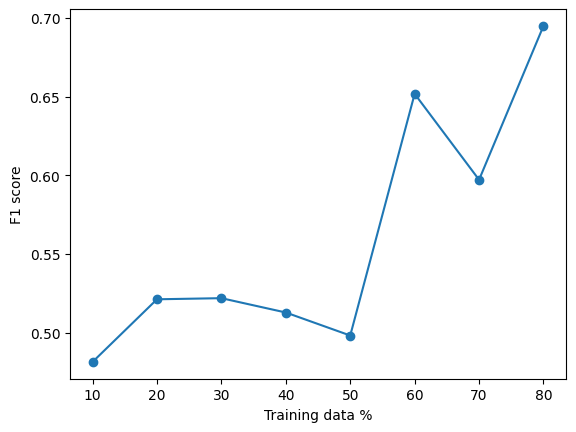

In [ ]:
growing_training_set_plot(wine, 10, 90, 10, get_x_and_y_wine, MulticlassLogisticRegression, "F1 score")

## JOB 4


In [ ]:
def growing_batch_size_plot(data, start, end, step, get_x_y_fn, model_class, performance_metric):
  results = []
  x = []
  training,test = split_data(data)
  x_training, y_training = get_x_y_fn(training)
  model = model_class()
  x_test, y_test = get_x_y_fn(test)
  for i in range(start, end, step):
    x.append(2 ** i)
    model.fit(x_training, y_training, optimizer=StochasticGradientDescent(learning_rate=1e-6,max_iters=1000, batch_size = 2 ** i))
    results.append(model.get_stats(x_test, y_test)[0])
  plt.plot(x, results, marker='o')
  plt.xlabel("Batch size")
  plt.ylabel(performance_metric)
  plt.show()


### Applied to boston dataset

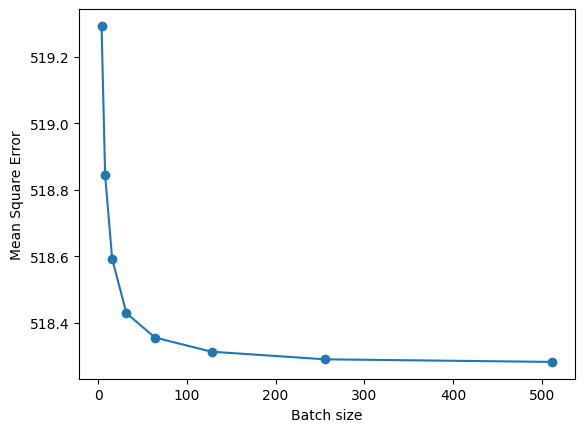

In [ ]:
growing_batch_size_plot(boston, 2, 10, 1, get_x_and_y_boston, LinearRegression, "Mean Square Error")

### Applied to wine dataset

Note that the Errors are due to the confusion matrix having empty entries which are relevant to the precision and recall, and so we divide by 0 which leads to Nan, but other than that we clearly see that the greater the batch size the greater the F1 score

<ipython-input-15-7d2cb49ff781>:78: RuntimeWarning: invalid value encountered in divide
  precision = confusion_df.iloc[:-1, :-1].to_numpy().diagonal() / \
<ipython-input-15-7d2cb49ff781>:78: RuntimeWarning: invalid value encountered in divide
  precision = confusion_df.iloc[:-1, :-1].to_numpy().diagonal() / \
<ipython-input-15-7d2cb49ff781>:78: RuntimeWarning: invalid value encountered in divide
  precision = confusion_df.iloc[:-1, :-1].to_numpy().diagonal() / \
<ipython-input-15-7d2cb49ff781>:78: RuntimeWarning: invalid value encountered in divide
  precision = confusion_df.iloc[:-1, :-1].to_numpy().diagonal() / \
<ipython-input-15-7d2cb49ff781>:78: RuntimeWarning: invalid value encountered in divide
  precision = confusion_df.iloc[:-1, :-1].to_numpy().diagonal() / \
<ipython-input-15-7d2cb49ff781>:78: RuntimeWarning: invalid value encountered in divide
  precision = confusion_df.iloc[:-1, :-1].to_numpy().diagonal() / \


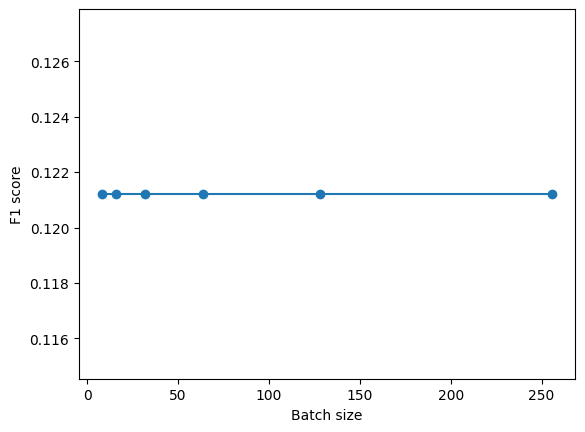

In [ ]:
growing_batch_size_plot(wine, 3, 9, 1, get_x_and_y_wine, MulticlassLogisticRegression, "F1 score")

## JOB 5

In [ ]:
def different_learning_rates(data, learning_rates, get_x_y_fn, model_class, performance_metric):
  results = []

  training,test = split_data(data)
  x_training, y_training = get_x_y_fn(training)
  model = model_class()
  x_test, y_test = get_x_y_fn(test)

  for learning_rate in learning_rates:
    model.fit(x_training, y_training, optimizer=StochasticGradientDescent(learning_rate=learning_rate,max_iters=10000, batch_size = 32))
    results.append(model.get_stats(x_test, y_test)[0])
  plt.plot(learning_rates, results, marker='o')
  plt.xlabel("Learning rates")
  plt.ylabel(performance_metric)
  plt.xscale("log")
  plt.show()




### Applied to boston data set

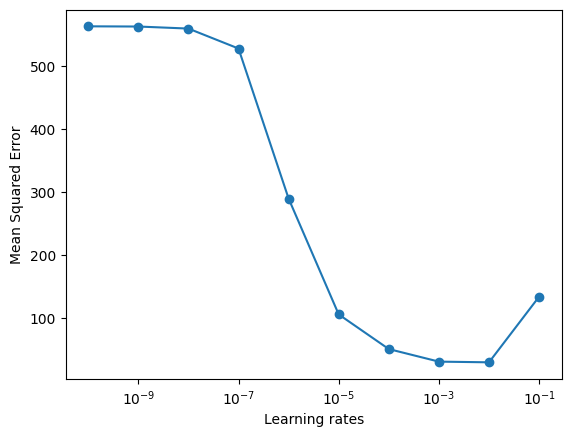

In [ ]:
different_learning_rates(boston, [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], get_x_and_y_boston, LinearRegression, "Mean Squared Error")

### Applied to wine data set

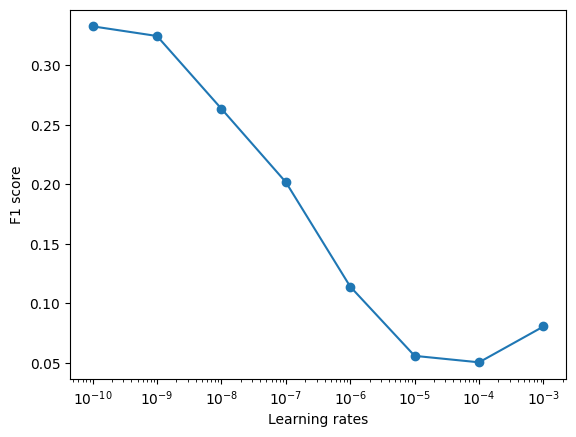

In [ ]:
different_learning_rates(wine, [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3], get_x_and_y_wine, LinearRegression, "F1 score")

## JOB 6

### For Both data set
We already experimented with various learning rates and batch sizes in the above jobs, for instance for boston:
- We will use the Mean Squared Error (MSE) as a performance metric as it encompasses well the idea of how off from the test set is our model
- **learning_rate = 1e-3** : Seeing the learning rate to MSE plot performed in Job 5, we are confident claiming that a learning rate of 1e-3 is optimal
- **batch_size = 256** : Job 4 also showed that the greater the batch size, but anything more than 250 doesnt improve our metric much and so we will settle for 256 as the batch size

As for wine data set:
- We will be using average F1_score as a performance metric as it encompasses both the recall and precision in one metric
- **learning_rate = 1e-10** : Seeing as the smaller the learning rate the better our F1 score was in job 5, we will use 1e-10, anything smaller may be too slow fto converge in "max_iters" iterations
- **batch_size = 128** : It seems through the plot we made in job 4 that we get a great increase in F1 score after batch_size = 64 but, just to be safe, we will use 128

Need to experiment for the following parameters :
- **B_momentum = ?**
- **B_adaptive = ?**
- **max_iters = ?**


#### B_momentum

In [ ]:
def different_B_momentum(data, start, stop, step, get_x_y_fn, model_class, performance_metric):
  results = []
  x = []
  training,test = split_data(data)
  x_training, y_training = get_x_y_fn(training)
  model = model_class()
  x_test, y_test = get_x_y_fn(test)

  for B_momentum in range(start, stop, step):
    x.append(B_momentum)
    model.fit(x_training, y_training, optimizer=StochasticGradientDescent(learning_rate = 1e-10,B_momentum=B_momentum * 0.01,
                                                                          max_iters=1000))
    results.append(model.get_stats(x_test, y_test)[0])
  plt.plot(x, results, marker='o')
  plt.xlabel("B Momentum")
  plt.ylabel(performance_metric)
  plt.show()

##### Applied to Boston

With this next graph, we can confidently state that larger the B_mommentum the better MSE, and so we want to set B_mommentum = 0.99

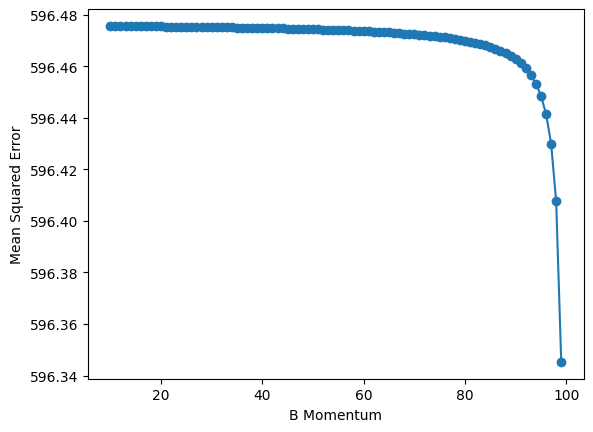

In [ ]:
different_B_momentum(boston, 10, 100, 1, get_x_and_y_boston, LinearRegression, "Mean Squared Error")

##### Applied to wine

There doesnt seem to be a preferable parameter for B_mommentum and so I will leave it at the default for Logistic Regression

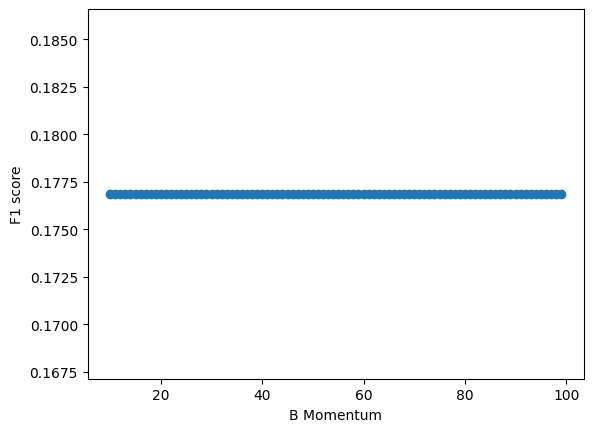

In [ ]:
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  different_B_momentum(wine, 10, 100, 1, get_x_and_y_wine, MulticlassLogisticRegression, "F1 score")

#### B_adaptive

In [ ]:
def different_B_adaptive(data, start, stop, step, get_x_y_fn, model_class, performance_metric):
  results = []
  x = []
  training,test = split_data(data)
  x_training, y_training = get_x_y_fn(training)
  model = model_class()
  x_test, y_test = get_x_y_fn(test)

  for B_adaptive in range(start, stop, step):
    x.append(B_adaptive)
    model.fit(x_training, y_training,
              optimizer=StochasticGradientDescent(learning_rate = 1e-10,
                                                  B_adaptive=B_adaptive * 0.01, max_iters=1000))
    results.append(model.get_stats(x_test, y_test)[0])
  plt.plot(x, results, marker='o')
  plt.xlabel("B Adaptive")
  plt.ylabel(performance_metric)
  plt.show()

##### Applied to boston

It seems that lower B adaptive values lead to smaller MSE for Boston data set, and so we may as well set it to 0

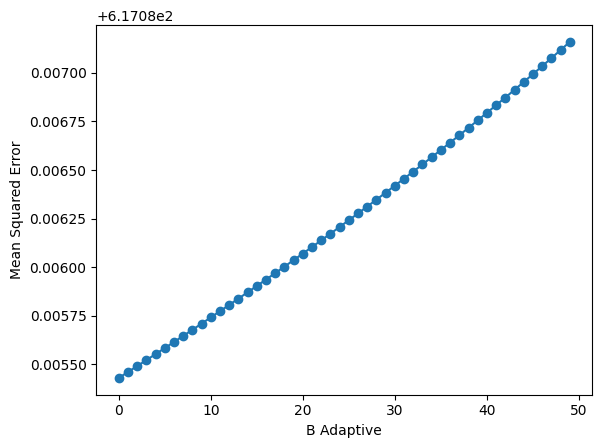

In [ ]:
different_B_adaptive(boston, 0, 50, 1, get_x_and_y_boston, LinearRegression, "Mean Squared Error")

##### Applied to wine

Once again our multiclass regression doesnt seem to care much and so we will leave it to the default value

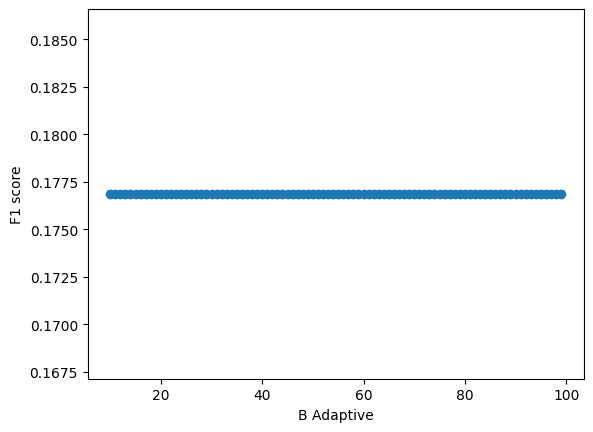

In [ ]:
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  different_B_adaptive(wine, 10, 100, 1, get_x_and_y_wine, MulticlassLogisticRegression, "F1 score")

#### max_iters

In [ ]:
def different_max_iters(data, start, stop, step, get_x_y_fn, model_class, performance_metric):
  results = []
  x = []
  training,test = split_data(data)
  x_training, y_training = get_x_y_fn(training)
  model = model_class()
  x_test, y_test = get_x_y_fn(test)

  for max_iters in range(start, stop, step):

    x.append(10 ** max_iters)
    model.fit(x_training, y_training, optimizer=StochasticGradientDescent(learning_rate=1e-8,
                                                                          max_iters=10 ** max_iters, batch_size = 256))
    results.append(model.get_stats(x_test, y_test)[0])
  plt.plot(x, results, marker='o')
  plt.xlabel("max_iters")
  plt.ylabel(performance_metric)
  plt.xscale("log")
  plt.show()

##### Applied on boston

It seems that the larger the max_iters is, the better for the boston data set, However I think its okay to keep it at 1e6 just not to spend too much time

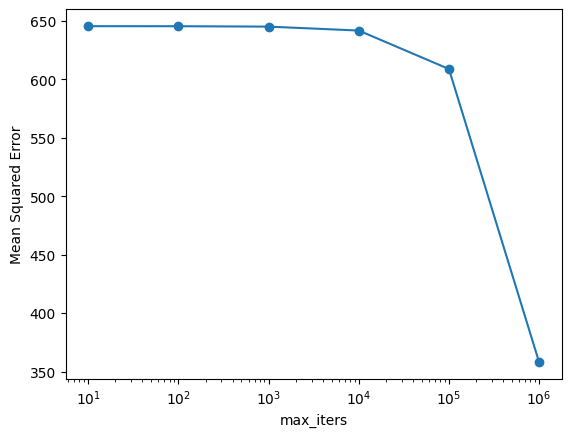

In [ ]:
different_max_iters(boston, 1, 7, 1, get_x_and_y_boston, LinearRegression, "Mean Squared Error")

##### Applied on wine dataset

Once again, the longer the better but We will settle for 1e6

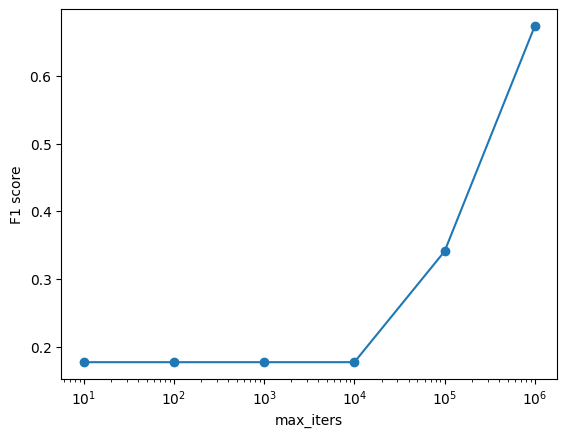

In [ ]:
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  different_max_iters(wine, 1, 7, 1, get_x_and_y_wine, MulticlassLogisticRegression, "F1 score")


### Final Verdict On parameters:
  1. for Boston data set:
    - learning_rate = 1e-3
    - batch_size = 256
    - B_momentum = 0.99
    - B_adaptive = 0
    - max_iters = 1e6
  2. for wine data set:
    - learning_rate = 1e-10
    - batch_size = 128
    - B_momentum = 0.5
    - B_adaptive = 0.5
    - max_iters = 1e6

## JOB 7

### Without Gaussians

In [ ]:
def Gaussian_less_LR():
  training, test = split_data(boston, shuffle=False)
  x_training, y_training = get_x_and_y_boston(training)
  x_test, y_test = get_x_and_y_boston(test)
  model = LinearRegression()
  model.fit(x_training, y_training)
  print("Training performance = ")
  model.print_stats(x_training, y_training)
  print("Test performance = ")
  model.print_stats(x_test, y_test)
Gaussian_less_LR()

Training performance = 
Mean Square Error = 22.783597458171922
Test performance = 
Mean Square Error = 30.556542476065477


### With Gaussians (and previously mentionned modification in the data, see TASK 2)

In [ ]:
def Gaussian_full_LR(num_gaussians):



# boston_transformed.loc[:, ["CRIM", "INDUS", "LSTAT"]] = \
# (boston_transformed.loc[:, ["CRIM", "INDUS", "LSTAT"]])\
# .apply( lambda x: 1/(x) , axis = 1)

# boston_transformed.loc[:, "AGE"] = \
# (boston_transformed.loc[:, "AGE"])\
# .apply( lambda x: np.sqrt(-x + 100))
  s = 1.
  boston_gaussian = boston.copy()
  # for column in boston_gaussian.columns.drop("MEDV"):
  #   mean = np.mean(boston_gaussian.loc[:, column].to_numpy())
  #   gaussian_column = lambda x: np.exp( - (x - mean)**2 / (2 * s**2))
  #   boston_gaussian.loc[:, column] = boston_gaussian.loc[:, column].apply(gaussian_column)




  length = len(boston_gaussian.columns)
  while True:
    boston_transformed = boston_gaussian.copy()
    for i in range(num_gaussians):
      # i % len(boston_transformed.columns)
      mean = np.random.choice(boston_transformed.iloc[:, i].to_numpy())

      def gaussian(x):
        return np.exp( - (x - mean)**2 / (2 * s**2))
      modified_column = (boston_transformed.iloc[:,i % length])
      modified_column = modified_column.apply(gaussian)
      boston_transformed[f"Gaussian #{i} with mean = {mean}"] = modified_column

    training, test = split_data(boston_transformed, shuffle=False)
    x_training, y_training = get_x_and_y_boston(training)
    if (np.linalg.det(x_training.T @ x_training) != 0):
      break


  model = LinearRegression()
  model.fit(x_training, y_training)
  x_test, y_test = get_x_and_y_boston(test)
  print(f"Training performance :")
  model.print_stats(x_training, y_training)
  print(f"Test performance : ")
  model.print_stats(x_test, y_test)
Gaussian_full_LR(5)

Training performance :
Mean Square Error = 2979.8603054685136
Test performance : 
Mean Square Error = 16443.344535875094


## JOB 8

In [ ]:
def SDG_vs_A():
  training, test = split_data(boston)
  x_training, y_training = get_x_and_y_boston(training)
  model = LinearRegression()
  x_test, y_test = get_x_and_y_boston(test)
  model.fit(x_training, y_training)
  print(f"Analytical Result MSE = ")
  model.print_stats(x_test, y_test)

  model.fit(x_training, y_training,
            optimizer=StochasticGradientDescent(learning_rate=1e-4,
                                                batch_size=256, B_momentum=0.6,
                                                B_adaptive=0., max_iters=1e6))
  print(f"Stochastic Gradient descent MSE = ")
  model.print_stats(x_test, y_test)
SDG_vs_A()

Analytical Result MSE = 
Mean Square Error = 20.629391878200178
Stochastic Gradient descent MSE = 
Mean Square Error = 32.5832317576866
